In [1]:
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.models import Model
import scipy
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from matplotlib.patches import Rectangle
from skimage.feature.peak import peak_local_max
import random 

In [2]:
input_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset/')
output_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/')

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8,.2))

Copying files: 7324 files [00:11, 633.77 files/s]


In [3]:
train_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/train/')
val_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/val/')

In [4]:
def image_generator(train_parent_directory, val_parent_directory):
    train_datagen = ImageDataGenerator(rescale=1/255)
    val_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                       target_size=(224,224),
                                                        batch_size=140,
                                                        class_mode='categorical',
                                                        subset='training')
    
    val_generator = val_datagen.flow_from_directory(val_parent_directory,
                                                     target_size=(224,224),
                                                      batch_size=37,
                                                      class_mode='categorical')
    
    return train_generator, val_generator

In [5]:
train_generator, val_generator = image_generator(train_dir, val_dir)

Found 5859 images belonging to 2 classes.
Found 1465 images belonging to 2 classes.


In [6]:
tfd = tfp.distributions
tfpl = tfp.layers

In [7]:
def create_bayesian_model(input_shape=(224, 224, 3), num_classes=2, divergence_fn=None):
    if divergence_fn is None:
        def divergence_fn(q, p, _):
            return tfp.distributions.kl_divergence(q, p) / 8569

    model = Sequential([
        tfpl.Convolution2DReparameterization(
            input_shape=input_shape, 
            filters=4, 
            kernel_size=8, 
            activation='relu',
            kernel_prior_fn=tfpl.default_multivariate_normal_fn,
            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn=divergence_fn,
            bias_prior_fn=tfpl.default_multivariate_normal_fn,
            bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn=divergence_fn
        ),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        tfpl.DenseReparameterization(
            units=tfpl.OneHotCategorical.params_size(num_classes), 
            activation=None,
            kernel_prior_fn=tfpl.default_multivariate_normal_fn,
            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn=divergence_fn,
            bias_prior_fn=tfpl.default_multivariate_normal_fn,
            bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn=divergence_fn
        ),
        tfpl.OneHotCategorical(num_classes)
    ])

    return model

In [8]:
model_bayes = create_bayesian_model(input_shape=(224, 224, 3), num_classes=2)

D:\Anaconda\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
D:\Anaconda\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [9]:
model_bayes.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 217, 217, 4)      1544      
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 108, 4)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 106, 106, 32)      1184      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 51, 64)        18496     
                                                        

In [10]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [11]:
history_bayes = model_bayes.fit(
      train_generator,
      validation_data=val_generator,
      epochs=100,
      verbose=1)

Epoch 1/100
42/42 [==============================] - 144s 3s/step - loss: 1.2033 - accuracy: 0.5458 - val_loss: 1.1249 - val_accuracy: 0.5652
Epoch 2/100
42/42 [==============================] - 135s 3s/step - loss: 1.0557 - accuracy: 0.6228 - val_loss: 1.0083 - val_accuracy: 0.6997
Epoch 3/100
42/42 [==============================] - 135s 3s/step - loss: 0.9523 - accuracy: 0.7105 - val_loss: 0.9027 - val_accuracy: 0.7379
Epoch 4/100
42/42 [==============================] - 136s 3s/step - loss: 0.8716 - accuracy: 0.7674 - val_loss: 0.8213 - val_accuracy: 0.7829
Epoch 5/100
42/42 [==============================] - 135s 3s/step - loss: 0.7867 - accuracy: 0.8153 - val_loss: 0.7868 - val_accuracy: 0.8184
Epoch 6/100
42/42 [==============================] - 135s 3s/step - loss: 0.7479 - accuracy: 0.8539 - val_loss: 0.6921 - val_accuracy: 0.8676
Epoch 7/100
42/42 [==============================] - 135s 3s/step - loss: 0.6663 - accuracy: 0.8976 - val_loss: 0.6510 - val_accuracy: 0.9065
Epoch 

42/42 [==============================] - 135s 3s/step - loss: 0.5117 - accuracy: 0.9997 - val_loss: 0.5232 - val_accuracy: 0.9966
Epoch 59/100
42/42 [==============================] - 135s 3s/step - loss: 0.5111 - accuracy: 0.9993 - val_loss: 0.5209 - val_accuracy: 0.9973
Epoch 60/100
42/42 [==============================] - 135s 3s/step - loss: 0.5107 - accuracy: 0.9995 - val_loss: 0.5225 - val_accuracy: 0.9952
Epoch 61/100
42/42 [==============================] - 135s 3s/step - loss: 0.5102 - accuracy: 0.9993 - val_loss: 0.5242 - val_accuracy: 0.9959
Epoch 62/100
42/42 [==============================] - 135s 3s/step - loss: 0.5099 - accuracy: 0.9997 - val_loss: 0.5199 - val_accuracy: 0.9973
Epoch 63/100
42/42 [==============================] - 135s 3s/step - loss: 0.5092 - accuracy: 0.9998 - val_loss: 0.5182 - val_accuracy: 0.9966
Epoch 64/100
42/42 [==============================] - 136s 3s/step - loss: 0.5088 - accuracy: 0.9995 - val_loss: 0.5227 - val_accuracy: 0.9966
Epoch 65/100

In [12]:
_,train_acc = model_bayes.evaluate(train_generator)
print('Accuracy of train datasets = ', (train_acc * 100.0), "%")

_,valid_acc = model_bayes.evaluate(val_generator)
print('Accuracy of valid datasets = ', (valid_acc * 100.0), "%")

42/42 [==============================] - 29s 693ms/step - loss: 0.4874 - accuracy: 1.0000
Accuracy of train datasets =  100.0 %
40/40 [==============================] - 7s 178ms/step - loss: 0.5019 - accuracy: 0.9966
Accuracy of valid datasets =  99.65870380401611 %


In [13]:
size = 224
dataset = []
label = []

pneumothorax_images = os.listdir('Dataset2/test/Stroke/')
for i, image_name in enumerate(pneumothorax_images):
    image = cv2.imread('Dataset2/test/Stroke/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(1)
        
normal_images = os.listdir('Dataset2/test/Normal/')
for i, image_name in enumerate(normal_images):
    image = cv2.imread('Dataset2/test/Normal/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(0)

dataset = np.array(dataset)
label = np.array(label)

In [14]:
X_test = dataset
y_test = label

In [15]:
X_test = X_test/255.
y_test = to_categorical(y_test)

79/79 [==============================] - 7s 88ms/step


<Axes: >

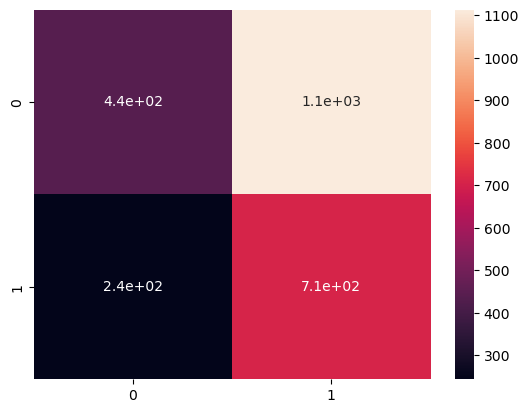

In [16]:
y_pred = np.argmax(model_bayes.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True)

In [17]:
pneumothorax_images_idx = np.where(y_pred == 1)[0]
predicted_as_para = []
for i in pneumothorax_images_idx:
    pneu_img = X_test[i]
    predicted_as_para.append(pneu_img)
    
predicted_as_para = np.array(predicted_as_para)

In [18]:
def plot_heatmap(img):
    pred = model_bayes.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    last_layer_weights = model_bayes.layers[-1].get_weights()[0]
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    last_conv_model = Model(model_bayes.input, model_bayes.get_layer("one_hot_categorical").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 64)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    heat_map[img[:,:,0] == 0] = 0 
     
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))


In [19]:
image = random.randint(0,predicted_as_para.shape[0]-1)
heat_map = plot_heatmap(predicted_as_para[image])

img = predicted_as_para[image]
plt.imshow(predicted_as_para[img])

1/1 [==============================] - 0s 41ms/step


IndexError: list index out of range

In [20]:
model_bayes.save("bayesian_model")
model = tf.saved_model.load("bayesian_model")
loaded_model = tf.keras.models.load_model("bayesian_model", compile=False)
loaded_model.summary()

INFO:tensorflow:Assets written to: bayesian_model\assets


INFO:tensorflow:Assets written to: bayesian_model\assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 217, 217, 4)      1544      
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 108, 4)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 106, 106, 32)      1184      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 51, 64)        18496     
                                                        